## 1. DATA PRE-PROCESSING

In [1]:
import pandas as pd
import numpy as np

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

### 1.1 Data Manipulation

In [2]:
# load data
data = pd.read_csv('/Users/junyuchen/Desktop/Master Thesis/code/data/gaa.csv', parse_dates=['vertrag'], index_col=['vertrag'], low_memory=False)
data.index = data.index.to_period('Q').rename('period')
#data.index.astype(str)

# select variables
data = data[['kalender', 'flaeche', 'gflaeche', 'alter', 'preis']]
data.rename(
    columns = {
        'kalender' : 'period_string',
        'flaeche' : 'lot_size',
        'gflaeche' : 'floor_space',
        'alter' : 'age',
        'preis' : 'price'
    }, inplace=True)

print(f'\nOriginal number of observations: {len(data)}.')

# 1. drop 2017q2
data = data.loc[data['period_string'] != '2017q2', :]
print(f'\nNumber of observations after dropping "2017q2": {len(data)}.')

# 2. drop negative "alter"
data = data.loc[data["age"] > 0]
print(f'\nNumber of observations after dropping negative "alter": {len(data)}.')

# 3. drop NaNs
data.dropna(inplace=True)
print(f'\nNumber of observations after dropping NANs: {len(data)}.')

data


Original number of observations: 37203.

Number of observations after dropping "2017q2": 37161.

Number of observations after dropping negative "alter": 29900.

Number of observations after dropping NANs: 29900.


,period_string,lot_size,floor_space,age,price
period,,,,,
1996Q1,1996q1,480,120,65,242864
1996Q2,1996q2,691,151,61,127823
1996Q3,1996q3,888,164,46,224968
1996Q1,1996q1,750,196,60,178952
1996Q2,1996q2,1105,163,66,230081
...,...,...,...,...,...
2017Q1,2017q1,733,144,82,369000
2017Q1,2017q1,249,117,36,349000
2017Q1,2017q1,714,102,44,340000


#### Logarithm Transformation of Variables

In [3]:
data_log = data.copy()
data_log.loc[:, [
    'lot_size', 'floor_space', 'age', 'price'
]] = np.log(data_log.loc[:, [
    'lot_size', 'floor_space', 'age', 'price'
]])

data_trend = pd.DataFrame({
    'trend' : np.array(range(1, 86)),
    'trend2' : np.power(range(1, 86), 2),
    'period_string' : sorted(pd.unique(data_log['period_string']))
})

data_log = data_log.merge(data_trend, on='period_string', how='left').set_axis(data_log.index)

data_log.head()

,period_string,lot_size,floor_space,age,price,trend,trend2
period,,,,,,,
1996Q1,1996q1,6.173786,4.787492,4.174387,12.400257,1,1
1996Q2,1996q2,6.538140,5.017280,4.110874,11.758402,2,4
1996Q3,1996q3,6.788972,5.099866,3.828641,12.323713,3,9
1996Q1,1996q1,6.620073,5.278115,4.094345,12.094873,1,1
1996Q2,1996q2,7.007601,5.093750,4.189655,12.346187,2,4


### 1.2 Missing Observations

$\boldsymbol{y}_t$ is a $N_{t} \times 1$ vector of observable variables at time $t$, where $N_{t}$ denotes the number of observations $\boldsymbol{y}_{t,n}$ in period $t$. Due to the variation of the number of observations over time, we set $N$ to the number of minimum (instead of maximum) observations for a quarter:

$$
N = \min_{t=1,...,T} N_t
$$

In [4]:
# ---------------------------------------------------
# select observations
# ---------------------------------------------------
def select_observations(group):
    return group.sample(n=N, random_state=999)

# check the minimum number of observations 
print(f"Original number of observations for each quarter: \n{data_log.index.value_counts().sort_values()}")

# select the first N observations of each quarter
N = data_log.index.value_counts().sort_values()[0]
df = data_log.groupby(data_log.index).apply(select_observations).reset_index(level=0, drop=True)

print(f"\nThe total number of observations after dropping missing observations: {len(df)}.")
print(df.index.value_counts().sort_values())

Original number of observations for each quarter: 
1997Q1    192
2003Q1    198
1996Q1    201
2006Q1    206
2014Q1    214
         ... 
2010Q3    484
2010Q2    486
2011Q2    492
2006Q4    497
2005Q4    637
Freq: Q-DEC, Name: period, Length: 85, dtype: int64

The total number of observations after dropping missing observations: 16320.
1996Q1    192
1997Q1    192
1997Q2    192
1997Q3    192
1997Q4    192
         ... 
2016Q4    192
2012Q3    192
2012Q2    192
2015Q2    192
2017Q1    192
Freq: Q-DEC, Name: period, Length: 85, dtype: int64


## 2. REGRESSION

In [5]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.formula.api import ols
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

### 2.1 Hedonic Regression

The price function at time $t$:

$$
p_{t,n} = \beta_0 + \beta_{1} x_{t,n}^{\text{(lot size)}} + \beta_{2} x_{t,n}^{\text{(floor space)}} + \beta_{3} x_{t,n}^{\text{(age)}} + \gamma_{t} + \omega_{t,n}
$$

$$
p_{n} = \beta_0 + \beta_{1} x_{t,n}^{\text{(lot size)}} + \beta_{2} x_{t,n}^{\text{(floor space)}} + \beta_{3} x_{n}^{\text{(age)}} + \sum_{t=2}^{T} \gamma_{t} + \omega_{n}
$$

In [6]:
hedonic_reg = ols('price ~ lot_size + floor_space + age + period_string + trend + trend2', data=df).fit()
print(hedonic_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     163.1
Date:                Mon, 30 Oct 2023   Prob (F-statistic):               0.00
Time:                        18:29:18   Log-Likelihood:                -8488.0
No. Observations:               16320   AIC:                         1.715e+04
Df Residuals:                   16232   BIC:                         1.783e+04
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [17]:
print(hedonic_reg.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}           &      price       & \textbf{  R-squared:         } &     0.466   \\
\textbf{Model:}                   &       OLS        & \textbf{  Adj. R-squared:    } &     0.464   \\
\textbf{Method:}                  &  Least Squares   & \textbf{  F-statistic:       } &     163.1   \\
\textbf{Date:}                    & Mon, 30 Oct 2023 & \textbf{  Prob (F-statistic):} &     0.00    \\
\textbf{Time:}                    &     23:35:44     & \textbf{  Log-Likelihood:    } &   -8488.0   \\
\textbf{No. Observations:}        &       16320      & \textbf{  AIC:               } & 1.715e+04   \\
\textbf{Df Residuals:}            &       16232      & \textbf{  BIC:               } & 1.783e+04   \\
\textbf{Df Model:}                &          87      & \textbf{                     } &             \\
\textbf{Covariance Type:}         &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\

In [7]:
beta0 = hedonic_reg.params[0]
beta1 = hedonic_reg.params[-5]
beta2 = hedonic_reg.params[-4]
beta3 = hedonic_reg.params[-3]
beta4 = hedonic_reg.params[-2]
beta5 = hedonic_reg.params[-1]

sigma_omega_2 = hedonic_reg.mse_resid
print(beta0, beta1, beta2, beta3, beta4, beta5, sigma_omega_2)

7.914665307028585 0.16036025607380477 0.803396914915728 -0.08230825336924244 -0.02160460421190627 0.00029153541855823917 0.16658055580029402


In [8]:
np.exp(7.9146)

2736.9515307848346

The OLS estimates $\hat{\beta}_{0}, \hat{\beta}_{1}, \hat{\beta}_{2}, \hat{\beta}_{3}, \hat{\sigma}_{\omega}^{2}$ are obtained:

| Estimates by OLS                                     | |
| :--------------------------------------------------- | |
| $\hat{\beta}_{0}$                                    | $7.9146$  |
| $\hat{\beta}_{1} = \hat{\beta}_{\text{lot size}}$    | $0.1604$  |
| $\hat{\beta}_{2} = \hat{\beta}_{\text{floor space}}$ | $0.8034$  |
| $\hat{\beta}_{3} = \hat{\beta}_{\text{age}}$         | $-0.0823$ |
| $\hat{\beta}_{4} = \hat{\beta}_{\text{trend}}$       | $-0.0216$ |
| $\hat{\beta}_{5} = \hat{\beta}_{\text{trend2}}$      | $-0.0003$ |
| $\hat{\sigma}_{\omega}^{2}$                          | $0.1666$  |

and the estimated common price component $\hat{\Gamma} = \{ \hat{\gamma}_{1}, \hat{\gamma}_{2}, ...,  \hat{\gamma}_{T} \}$ (Note that $\hat{\gamma}_{0}$ is set to $0$):

In [9]:
gamma = hedonic_reg.params.copy()[0:-5].values
gamma[0] = 0

periods = pd.period_range(start="1996Q1", end="2017Q1", freq="Q")
gamma = pd.Series(gamma, index=periods)
gamma

1996Q1    0.000000
1996Q2   -0.056848
1996Q3    0.042540
1996Q4   -0.047257
1997Q1   -0.078108
            ...   
2016Q1    0.070260
2016Q2    0.176037
2016Q3    0.151145
2016Q4    0.096992
2017Q1    0.056606
Freq: Q-DEC, Length: 85, dtype: float64

### 2.2 Auto-Regressive (AR) Process

The commen price component can be written as an AR process. The Box-Jenkins Method is employed to identifying the specific AR model which consists of the following steps:

1. Identification
2. Estimation
3. Diagnostic Checking
4. Forecasting (irrelavent here)

The steps 2 and 3 might be iterated until a suitable model estimate has been found.

In [10]:
average_price = df.groupby(df.index, sort=True)['price'].mean()

# construct a dataframe
df_gamma = pd.DataFrame({
    "gamma": gamma, 
    "gamma_pct_change": 100 * gamma.pct_change().values,
    "average_log_price": average_price.values
})
df_gamma.index = df_gamma.index.to_timestamp()
df_gamma

,gamma,gamma_pct_change,average_log_price
1996-01-01,0.000000,NaN,12.521244
1996-04-01,-0.056848,-inf,12.488206
1996-07-01,0.042540,-174.831021,12.549949
1996-10-01,-0.047257,-211.088744,12.429482
1997-01-01,-0.078108,65.282666,12.447552
...,...,...,...
2016-01-01,0.070260,-31.556379,12.715635
2016-04-01,0.176037,150.549044,12.789614
2016-07-01,0.151145,-14.139988,12.814165
2016-10-01,0.096992,-35.828800,12.814381


In [11]:
print(gamma.mean())
print(data_log['price'].mean())

-0.0001620453167059806
12.347282436271646


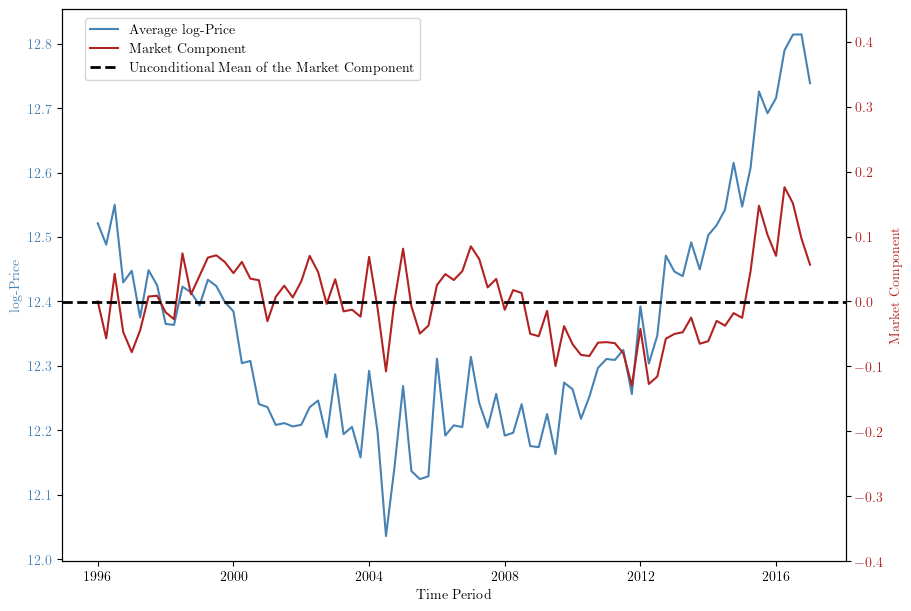

In [12]:
fig, ax1 = plt.subplots(figsize=(9,6), layout="constrained")

color1 = 'steelblue'
ax1.plot(df_gamma.index, df_gamma["average_log_price"], label='Average log-Price', color=color1)
ax1.set_xlabel('Time Period')
ax1.set_ylabel('log-Price', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'firebrick'
ax2 = ax1.twinx()
ax2.plot(df_gamma.index, df_gamma["gamma"], label='Market Component', color=color2)
plt. axhline(y=gamma.mean(), color='black', linestyle='--', linewidth=2, label='Unconditional Mean of the Market Component')
ax2.set_ylabel('Market Component', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([-0.4, 0.45])

fig.legend(loc='upper left',  bbox_to_anchor=(0.08,0.99))
plt.savefig('/Users/junyuchen/Desktop/Master Thesis/code/Plots/hedonic_index.png')
plt.show()

#### Identifying Serial Correlation

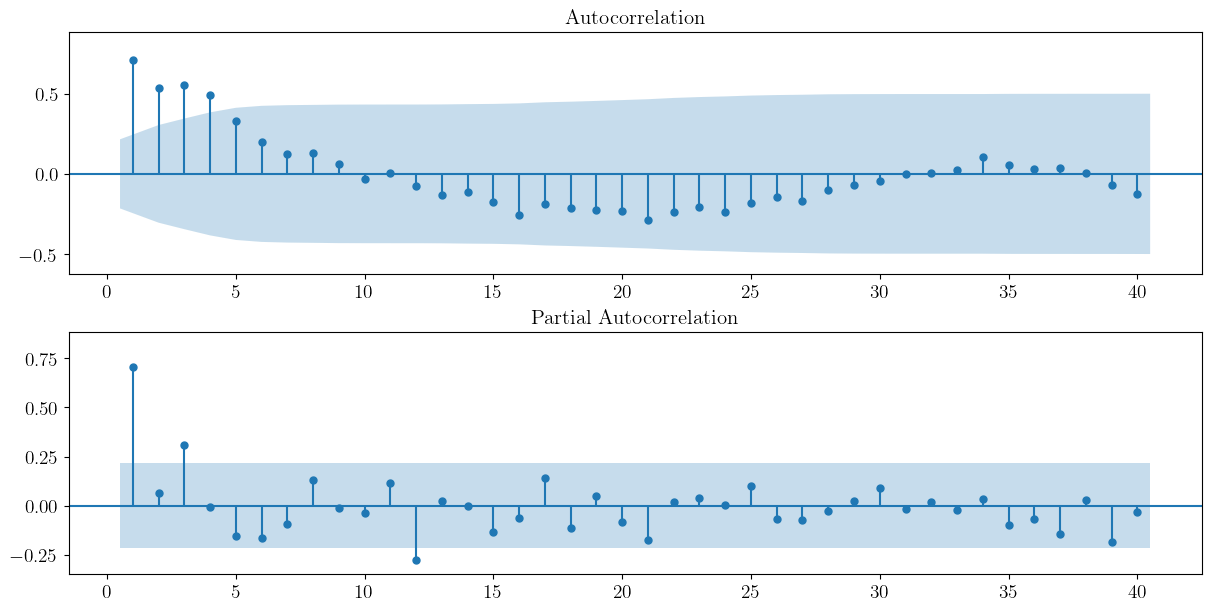

In [13]:
ls = 14

# ACF and PACF
fig = plt.figure(figsize=(12,6), layout="constrained")

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_gamma['gamma'].values[2:], lags=40, ax=ax1, alpha=0.05, zero=False, auto_ylims=True)
ax1.set_title('Autocorrelation', fontsize=15)
ax1.tick_params(axis='x', labelsize=ls)
ax1.tick_params(axis='y', labelsize=ls)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_gamma['gamma'].values[2:], lags=40, ax=ax2, alpha=0.05, zero=False, auto_ylims=True, method='ywm')
ax2.set_title('Partial Autocorrelation', fontsize=15)
ax2.tick_params(axis='x', labelsize=ls)
ax2.tick_params(axis='y', labelsize=ls)

plt.savefig('/Users/junyuchen/Desktop/Master Thesis/code/Plots/acf_pacf.png', dpi=600)
plt.show()

#### Estimating an AR(1) Model

$$
\gamma_{t} = \delta + \phi \cdot \gamma_{t-1} + \nu_{t}, \text{ where } \nu_{t} \sim N(0, \sigma_{\nu}^{2})
$$

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 142.981
Date:                Mon, 30 Oct 2023   AIC                           -279.961
Time:                        18:29:23   BIC                           -272.634
Sample:                             0   HQIC                          -277.014
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.016      0.078      0.938      -0.030       0.033
ar.L1          0.6903      0.092      7.483      0.000       0.510       0.871
sigma2         0.0020      0.000      6.776      0.0

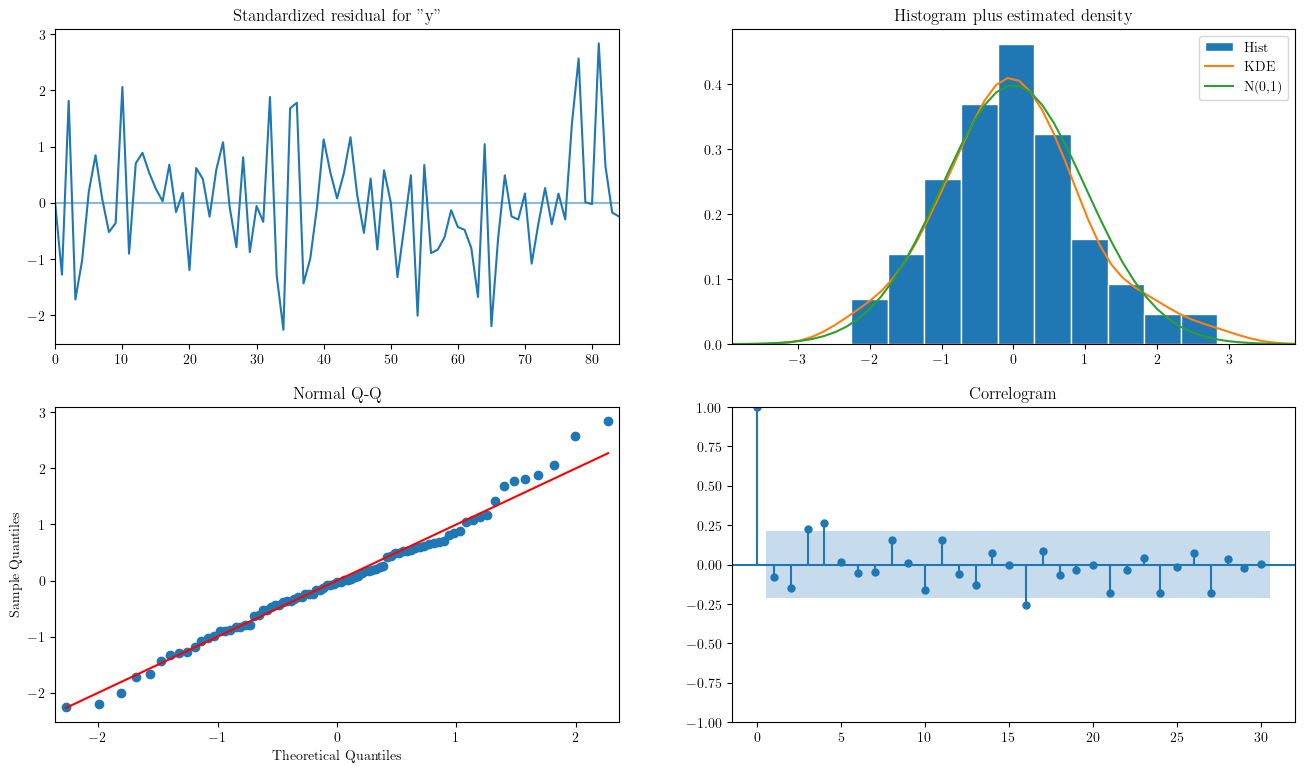

In [14]:
# ---------------------------------------------------
# MLE
# ---------------------------------------------------
ar1 = ARIMA(gamma.values, order=(1,0,0)).fit()
print(ar1.summary())

fig = plt.figure(figsize=(16, 9))
fig = ar1.plot_diagnostics(fig=fig, lags=30)
plt.show()

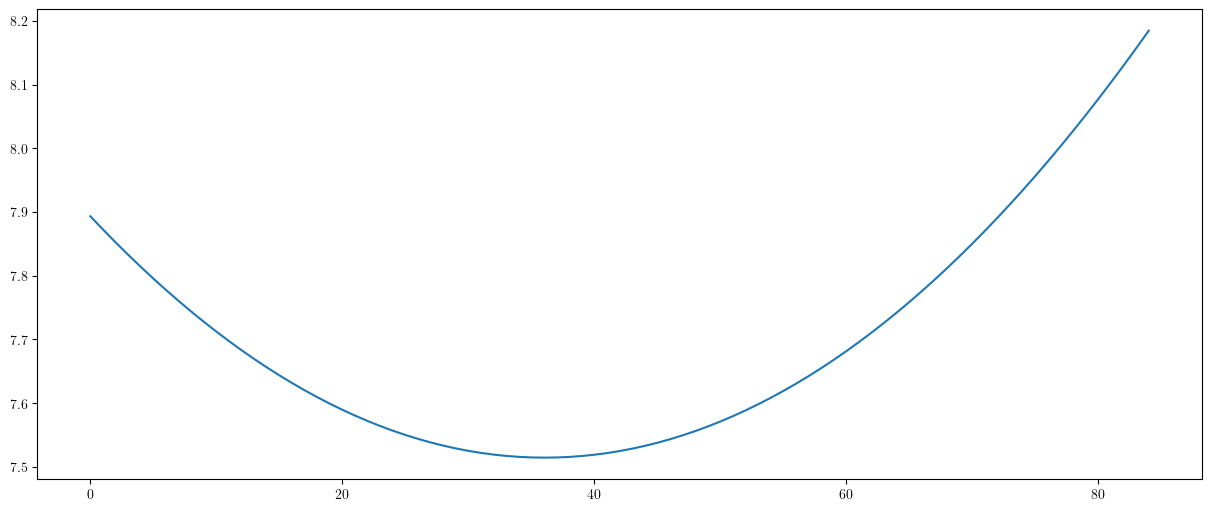

In [15]:
plt.figure(figsize=(12, 5), layout="constrained")
plt.plot(beta4 * data_trend['trend'] + beta5 * data_trend['trend2'] + beta0)

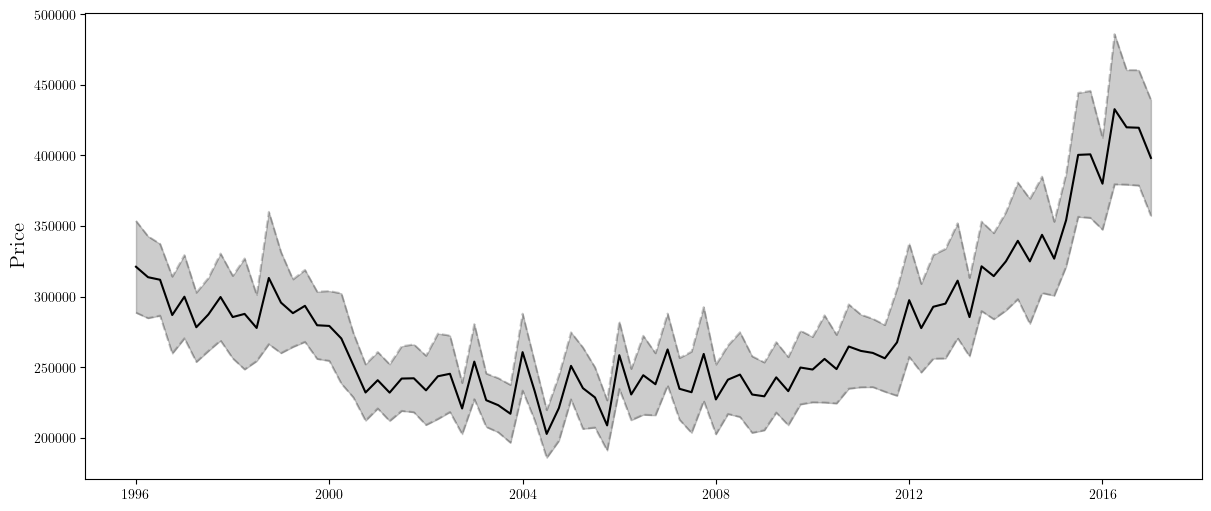

In [16]:
fs=15

average_price = data.groupby(data.index, sort=True)['price'].mean()
std = data.groupby(data.index, sort=True)['price'].std()
margin_of_error = 1.96 * (std / np.sqrt(N))  # 1.96 is the Z-score for a 95% confidence interval
x_axis = pd.period_range(start="1996Q1", end="2017Q1", freq="Q").to_timestamp()

color = 'black'
plt.figure(figsize=(12, 5), layout="constrained")
plt.plot(x_axis, average_price, color=color)
plt.fill_between(x_axis, 
                 average_price - margin_of_error, 
                 average_price + margin_of_error, 
                 color=color, alpha=0.2)
plt.plot(x_axis, average_price + margin_of_error, color=color, alpha=0.2, linestyle='--')
plt.plot(x_axis, average_price - margin_of_error, color=color, alpha=0.2, linestyle='--')

#plt.title('Average Price with 95$\%$ Confidence Interval', fontsize=fs)
#plt.xlabel('Time Period', fontsize=fs)
plt.ylabel('Price', fontsize=fs)

#plt.savefig('Plots/average_price_per_quarter.png')
plt.show()